In [181]:
import festim as F
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

small_flux_model = F.Simulation()
big_flux_model = F.Simulation()

In [182]:

vertices = np.concatenate([
    np.linspace(0, 30e-9, num=200),
    np.linspace(30e-9, 3e-6, num=300),
    np.linspace(3e-6, 20e-6, num=200),
])

small_flux_model.mesh = F.MeshFromVertices(vertices)

vertices = np.concatenate([
    np.linspace(0, 30e-9, num=400),
    np.linspace(30e-9, 3e-6, num=600),
    np.linspace(3e-6, 20e-6, num=400),
])

big_flux_model.mesh = F.MeshFromVertices(vertices)

In [183]:
# Material Setup, only W
#　Data from Table 1
tungsten = F.Material(
    id=1,
    D_0=4.1e-07,  # m2/s
    E_D=0.39,  # eV
)

small_flux_model.materials = tungsten
big_flux_model.materials = tungsten

In [184]:
import sympy as sp

small_imp_fluence = 1e22
big_imp_fluence = 1e23

flux_strength = 2.5e19 # beam strength from paper

small_imp_time = small_imp_fluence/flux_strength # s
big_imp_time = big_imp_fluence/flux_strength # s

small_ion_flux = sp.Piecewise((flux_strength, F.t <= small_imp_time), (0, True))
big_ion_flux = sp.Piecewise((flux_strength, F.t <= big_imp_time), (0, True))

small_source_term = F.ImplantationFlux(
    flux=small_ion_flux,  # H/m2/s
    imp_depth=4.5e-9,  # m
    width=2.5e-9,  # m
    volume=1
)

big_source_term = F.ImplantationFlux(
    flux=big_ion_flux,  # H/m2/s
    imp_depth=5.6e-9,  # m
    width=2.5e-9,  # m
    volume=1
)

small_flux_model.sources = [small_source_term]
big_flux_model.sources = [big_source_term]

In [185]:
#trap settings
w_atom_density = 6.3e28  # atom/m3

trap_1 = F.Trap(
        k_0=4.1e-7/(1.1e-10**2*6*w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=0.87,
        density=1.3e-3*w_atom_density,
        materials=tungsten
    )

trap_2 = F.Trap(
        k_0=4.1e-7/(1.1e-10**2*6*w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=1.0,
        density=4e-4*w_atom_density,
        materials=tungsten
    )

center = 4.5e-9
width = 2.5e-9
distribution = 1/(width*(2*sp.pi)**0.5) * sp.exp(-0.5*((F.x-center)/width)**2)

small_trap_3 = F.ExtrinsicTrap(
        k_0=4.1e-7/(1.1e-10**2*6*w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=1.5,
        phi_0=small_ion_flux,
        n_amax=1e-01*w_atom_density, f_a=distribution, eta_a=6e-4,
        n_bmax=1e-02*w_atom_density, f_b=sp.Piecewise((1e6, F.x < 1e-6), (0, True)), eta_b=2e-4,
        materials=tungsten
    )


center = 5.6e-9
width = 2.5e-9
distribution = 1/(width*(2*sp.pi)**0.5) * sp.exp(-0.5*((F.x-center)/width)**2)

big_trap_3 = F.ExtrinsicTrap(
        k_0=4.1e-7/(1.1e-10**2*6*w_atom_density),
        E_k=0.39,
        p_0=1e13,
        E_p=1.5,
        phi_0=big_ion_flux,
        n_amax=1e-01*w_atom_density, f_a=distribution, eta_a=6e-4,
        n_bmax=1e-02*w_atom_density, f_b=sp.Piecewise((1e6, F.x < 1e-6), (0, True)), eta_b=2e-4,
        materials=tungsten
    )

small_flux_model.traps = [trap_1, trap_2, small_trap_3]
big_flux_model.traps = [trap_1, trap_2, big_trap_3]

In [186]:
#boundary conditions
small_flux_model.boundary_conditions = [
    F.DirichletBC(surfaces=[1, 2], value=0, field=0)
]

big_flux_model.boundary_conditions = [
    F.DirichletBC(surfaces=[1, 2], value=0, field=0)
]

In [187]:
implantation_temp = 293  # K
temperature_ramp = 8  # K/s

small_start_tds = small_imp_time + 50  # s

small_flux_model.T = F.Temperature(
    value=sp.Piecewise(
        (implantation_temp, F.t < small_start_tds),
        (implantation_temp + temperature_ramp*(F.t-small_start_tds), True))
)

big_start_tds = big_imp_time + 50 # s

big_flux_model.T = F.Temperature(
    value=sp.Piecewise(
        (implantation_temp, F.t < big_start_tds),
        (implantation_temp + temperature_ramp*(F.t-big_start_tds), True))
)

In [188]:
small_flux_model.dt = F.Stepsize(
    initial_value=0.5,
    stepsize_change_ratio=1.1,
    max_stepsize=lambda t: 0.5 if t > small_start_tds else None,
    dt_min=1e-05,
    milestones=[small_start_tds],
)

small_flux_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-09,
    final_time=small_start_tds + 80 # time to reach max temp
)

big_flux_model.dt = F.Stepsize(
    initial_value=0.4,
    stepsize_change_ratio=1.05,
    max_stepsize=lambda t: 0.5 if t > big_start_tds else None,
    dt_min=1e-05,
    milestones=[big_start_tds],
)

big_flux_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-09,
    final_time=big_start_tds + 80
)

In [189]:
small_derived_quantities = F.DerivedQuantities(
    [
        F.TotalVolume("solute", volume=1),
        F.TotalVolume("retention", volume=1),
        F.TotalVolume("1", volume=1),
        F.TotalVolume("2", volume=1),
        F.TotalVolume("3", volume=1),
        F.HydrogenFlux(surface=1),
        F.HydrogenFlux(surface=2)
    ],
    # filename="tds/derived_quantities.csv"  # optional set a filename to export the data to csv
)

big_derived_quantities = F.DerivedQuantities(
    [
        F.TotalVolume("solute", volume=1),
        F.TotalVolume("retention", volume=1),
        F.TotalVolume("1", volume=1),
        F.TotalVolume("2", volume=1),
        F.TotalVolume("3", volume=1),
        F.HydrogenFlux(surface=1),
        F.HydrogenFlux(surface=2)
    ]
)

small_flux_model.exports = [small_derived_quantities]
big_flux_model.exports = [big_derived_quantities]

small_flux_model.initialise()
small_flux_model.run()

#big_flux_model.initialise()
#big_flux_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/komodo/anaconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        5.3e+02 s    Ellapsed time so far: 13.3 s


In [190]:
small_t = small_derived_quantities.t
small_flux_left = small_derived_quantities.filter(fields="solute", surfaces=1).data
small_flux_right = small_derived_quantities.filter(fields="solute", surfaces=2).data

small_flux_total = -np.array(small_flux_left) - np.array(small_flux_right)


#big_t = big_derived_quantities.t
#big_flux_left = big_derived_quantities.filter(fields="solute", surfaces=1).data
#big_flux_right = big_derived_quantities.filter(fields="solute", surfaces=2).data

#big_flux_total = -np.array(big_flux_left) - np.array(big_flux_right)

Text(0.5, 0, 'Temperature (K)')

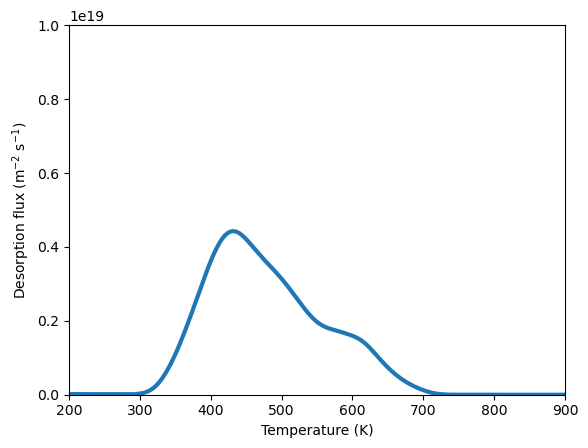

In [191]:
min_temp, max_temp = 200, 900

small_temp = [implantation_temp + 8*(t - small_start_tds) for t in small_t]
#big_temp = [implantation_temp + 8*(t - big_start_tds) for t in big_t]

plt.plot(small_temp, small_flux_total, linewidth=3)
#plt.plot(big_temp, big_flux_total, linewidth=3)

plt.xlim(min_temp, max_temp)
plt.ylim(bottom=0, top=1e19)
plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Temperature (K)")